# [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import seaborn as sns
sns.set(style="white", palette="colorblind", font_scale=1.2, 
        rc={"figure.figsize":(12,9)})

from sklearn.ensemble import RandomForestRegressor
from pdpbox import pdp
from scipy.cluster import hierarchy as hc
import scipy

from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import numpy as np
#from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import eli5
from eli5.sklearn import PermutationImportance
from concurrent.futures import ProcessPoolExecutor

PATH = 'C:\\Users\\Francesco\\Notebooks\\personal\\Kaggle\\Houses\\all\\'
RANDOM_STATE = 420
N_JOBS = 6

### Functions

In [201]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) 
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) 
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) 
    return df[~(df['Total'] == 0)] 

def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(9,6), legend=False, color='cornflowerblue')

def rmse(x,y): return math.sqrt(((np.log(x)-np.log(y))**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.
    Parameters:
    -----------
    df: The data frame you wish to process.
    y_fld: The name of the response variable
    skip_flds: A list of fields that dropped from df.
    ignore_flds: A list of fields that are ignored during processing.
    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)
    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.
    preproc_fn: A function that gets applied to df.
    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.
    subset: Takes a random subset of size subset from df.
    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).
    Returns:
    --------
    [x, y, nas, mapper(optional)]:
        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.
        y: y is the response variable
        nas: returns a dictionary of which nas it created, and the associated median.
        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> x, y, nas = proc_df(df, 'col1')
    >>> x
       col2
    0     1
    1     2
    2     1
    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])
    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])
    >>>round(fit_transform!(mapper, copy(data)), 2)
    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: pass
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: pass
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: pass
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: pass
    return res

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2
    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.
    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.
    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.
    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category { a : 1, b : 2}
    >>> numericalize(df, df['col2'], 'col3', None)
       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
        
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.
    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.
    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.
    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    note the type of col2 is string
    >>> train_cats(df)
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a
    now the type of col2 is category {a : 1, b : 2}
    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)
           col1 col2
        0     1    b
        1     2    a
        2     3    a
    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def swarmplot_with_cbar(cmap, cbar_label, *args, **kwargs):
    fig = plt.gcf()
    ax = sns.swarmplot(*args, **kwargs)
    ax.legend().remove()
    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="3%", pad=0.05)
    fig.add_axes(ax_cb)
    cb = ColorbarBase(ax_cb, cmap=cmap, orientation='vertical')
    cb.set_label(cbar_label, labelpad=10)
    
    return fig

def plot_pdp(model, dataset, model_features, feature, clusters=None):
    p = pdp.pdp_isolate(model, dataset, model_features, feature)
    return pdp.pdp_plot(p, feature, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters, plot_pts_dist=True)

def get_oob(df, col, params):
    m = RandomForestRegressor(n_estimators=params['n_estimators'], 
                              min_samples_leaf=params['min_samples_leaf'], 
                              max_features=params['max_features'],
                              n_jobs=-1, oob_score=True)
    cols = list(df.columns)
    if isinstance(col, list): 
        for c in col: cols.remove(c)
    else:     
        cols.remove(col)
    df_ = df.loc[:,cols]
    m.fit(df_, y_train)
    return m.oob_score_

### Data

In [7]:
data = pd.read_csv(f'{PATH}train.csv')
data.shape

(1460, 81)

In [8]:
display_all(data.tail(10).T)

,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459
Id,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460
MSSubClass,90,20,180,20,20,60,20,70,20,20
MSZoning,RL,RL,RM,RL,FV,RL,RL,RL,RL,RL
LotFrontage,60,78,35,90,62,62,85,66,68,75
LotArea,9000,9262,3675,17217,7500,7917,13175,9042,9717,9937
Street,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,Pave,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg,Reg
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub,AllPub


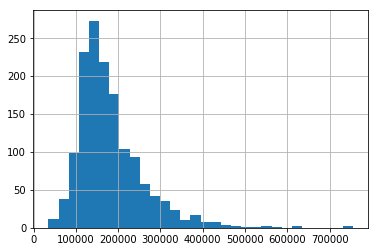

In [9]:
_ = data.SalePrice.hist(bins=30)

In [10]:
missing_values(data)

,Total,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


### Bayesian Hyperparameter tuning

In [11]:
data = data.sort_values(by='YrSold')

In [12]:
n_valid = 300
n_trn = len(data)-n_valid
raw_train, raw_valid = split_vals(data, n_trn)

raw_train.shape, raw_valid.shape

((1160, 81), (300, 81))

In [13]:
train_cats(raw_train)

X_train, y_train, nas = proc_df(raw_train, y_fld='SalePrice')

In [14]:
apply_cats(raw_valid, raw_train)

X_valid, y_valid, _ = proc_df(raw_valid, y_fld='SalePrice', na_dict=nas)

In [15]:
X_train.shape, X_valid.shape

((1160, 83), (300, 83))

In [16]:
display_all(X_train.head(10).T)

,781,1219,281,569,1220,571,1223,577,270,976
Id,782,1220,282,570,1221,572,1224,578,271,977
MSSubClass,60,160,20,90,20,20,20,80,60,30
MSZoning,4,5,2,4,4,4,4,4,2,4
LotFrontage,65,21,60,69,66,60,89,96,84,51
LotArea,7153,1680,7200,7032,7800,7332,10680,11777,10728,5900
Street,2,2,2,2,2,2,2,2,2,2
Alley,0,0,2,0,0,0,0,0,0,0
LotShape,4,4,4,1,1,4,4,1,4,1
LandContour,4,4,4,4,4,4,4,4,4,1
Utilities,1,1,1,1,1,1,1,1,1,1


In [17]:
%%time

rf_param_space = {
    'max_features': Real(0.2, 1),
    'n_estimators': Integer(20, 100), 
    'min_samples_leaf': Integer(4, 20)
}

m = RandomForestRegressor(n_jobs=-1, oob_score=True)

search = BayesSearchCV(m, 
                      rf_param_space, 
                      n_jobs=-1, 
                      verbose=0, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=25)

search.fit(X_train, y_train) 

Wall time: 1min 4s


In [18]:
search.best_params_

{'max_features': 0.3897268795836697, 'min_samples_leaf': 4, 'n_estimators': 66}

In [19]:
print_score(search.best_estimator_)

[0.09765382177484, 0.15489301110952292, 0.9333386119229383, 0.8892746516888966, 0.8397650132692264]


In [20]:
m = search.best_estimator_

### Feature Importance

In [21]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
17,OverallQual,0.303634
46,GrLivArea,0.134680
61,GarageCars,0.111266
19,YearBuilt,0.053505
27,ExterQual,0.047766
43,1stFlrSF,0.039297
62,GarageArea,0.038806
38,TotalBsmtSF,0.035103
34,BsmtFinSF1,0.026478
49,FullBath,0.025529


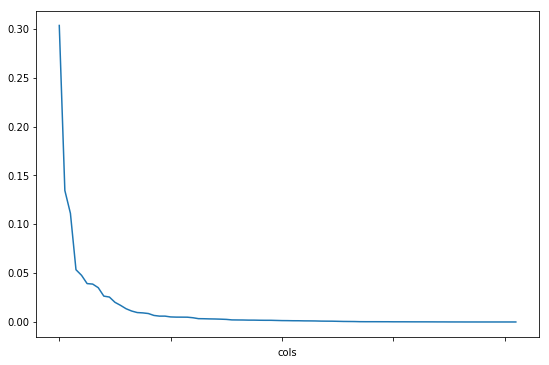

In [22]:
fi.plot('cols', 'imp', figsize=(9,6), legend=False);

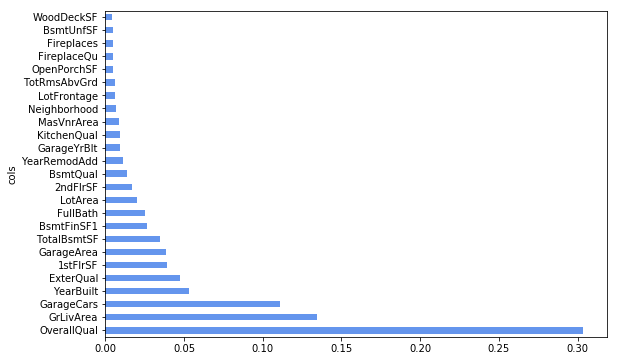

In [23]:
_ = plot_fi(fi[:25])

In [31]:
features = list(X_train.columns)

feat_imp_df = eli5.explain_weights_df(m, feature_names=features)
feat_imp_df.head(10)

,feature,weight,std
0,OverallQual,0.303634,0.215231
1,GrLivArea,0.134680,0.110640
2,GarageCars,0.111266,0.157040
3,YearBuilt,0.053505,0.108787
4,ExterQual,0.047766,0.118362
5,1stFlrSF,0.039297,0.058622
6,GarageArea,0.038806,0.086732
7,TotalBsmtSF,0.035103,0.062833
8,BsmtFinSF1,0.026478,0.030379
9,FullBath,0.025529,0.052730


In [36]:
perm_train = PermutationImportance(m, random_state=RANDOM_STATE)

perm_train.fit(X_train, y_train)
eli5.explain_weights_df(perm_train, feature_names=features).head(10)

,feature,weight,std
0,OverallQual,0.217247,0.009802
1,GrLivArea,0.121071,0.003796
2,GarageCars,0.040176,0.002306
3,1stFlrSF,0.021531,0.001048
4,YearBuilt,0.020198,0.001762
5,TotalBsmtSF,0.019654,0.000607
6,BsmtFinSF1,0.018624,0.000635
7,LotArea,0.015143,0.000548
8,GarageArea,0.012041,0.001343
9,ExterQual,0.010471,0.002128


In [43]:
top = list(eli5.explain_weights_df(perm_train, feature_names=features).head(10).feature)

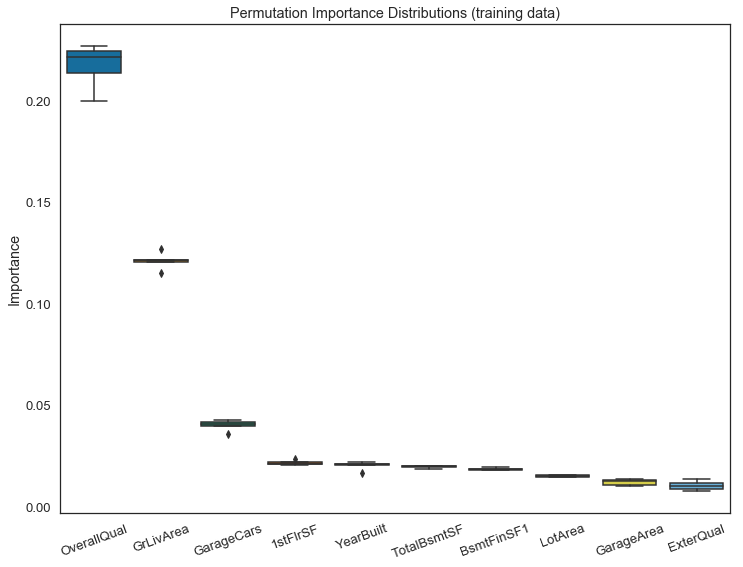

In [49]:
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_, columns=features)

fig, ax = plt.subplots()
(sns.boxplot(ax=ax, data=perm_train_feat_imp_df[top]).set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'))
plt.xticks(rotation=20);

### Trying a simpler model

In [186]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

X_train = X_train[to_keep].copy()
X_valid = X_valid[to_keep].copy()

X_train.shape, X_valid.shape

((1160, 21), (300, 21))

In [190]:
rf_param_space = {
    'max_features': Real(0.2, 1),
    'n_estimators': Integer(20, 100), 
    'min_samples_leaf': Integer(4, 20)
}

m = RandomForestRegressor(n_jobs=-1, oob_score=True)

search = BayesSearchCV(m, 
                      rf_param_space, 
                      n_jobs=-1, 
                      verbose=0, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=25)

search.fit(X_train, y_train);

In [191]:
search.best_params_

{'max_features': 0.4364853354797062,
 'min_samples_leaf': 4,
 'n_estimators': 100}

In [192]:
print_score(search.best_estimator_)

[0.10270095888630316, 0.15807418738096937, 0.928197408087566, 0.8904693767971557, 0.8356674070005083]


In [193]:
m = search.best_estimator_

In [195]:
features = list(X_train.columns)
perm_train = PermutationImportance(m, random_state=RANDOM_STATE)

perm_train.fit(X_train, y_train)
eli5.explain_weights_df(perm_train, feature_names=features).head(10)

,feature,weight,std
0,OverallQual,0.235740,0.013357
1,GrLivArea,0.141724,0.006585
2,GarageCars,0.037083,0.004248
3,TotalBsmtSF,0.028786,0.001265
4,1stFlrSF,0.027869,0.001808
5,BsmtFinSF1,0.027445,0.001142
6,LotArea,0.019002,0.000769
7,YearBuilt,0.016787,0.000621
8,GarageArea,0.014619,0.000784
9,ExterQual,0.014360,0.001622


In [196]:
top = list(eli5.explain_weights_df(perm_train, feature_names=features).head(10).feature)

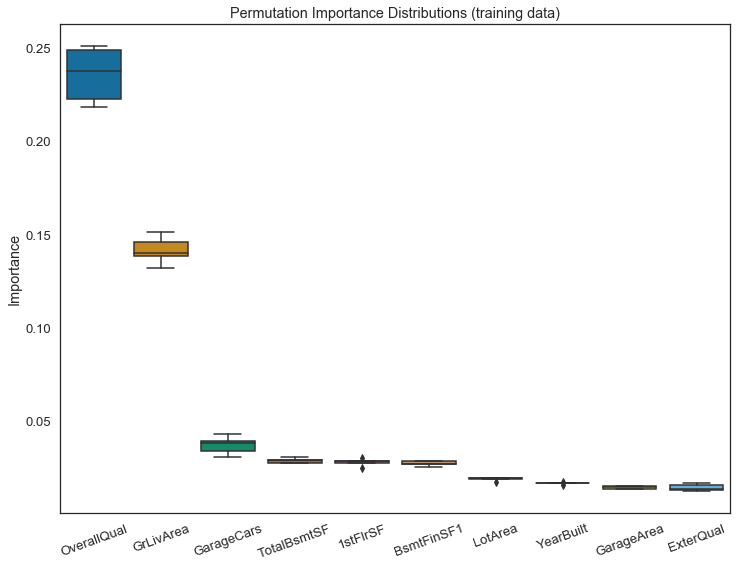

In [197]:
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_, columns=features)

fig, ax = plt.subplots()
(sns.boxplot(ax=ax, data=perm_train_feat_imp_df[top]).set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'))
plt.xticks(rotation=20);

### Removing redundant features

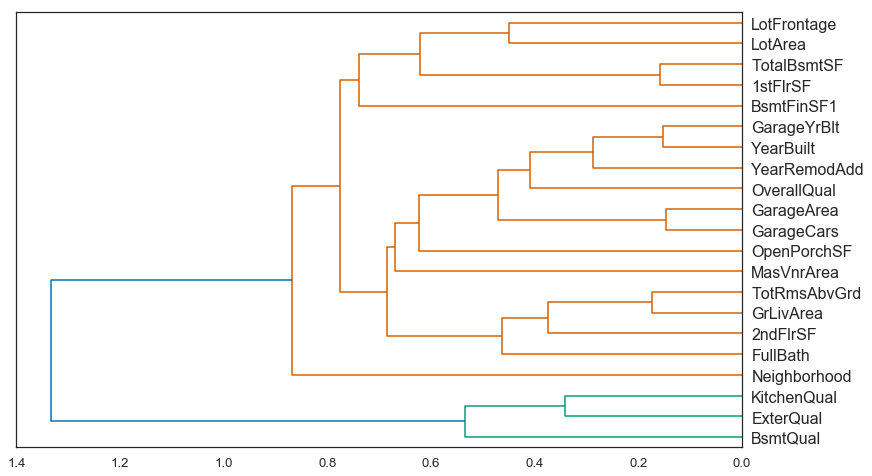

In [199]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(13,8))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [203]:
for col in ['GarageCars', 'GarageArea', 
            '1stFlrSF', 'TotalBsmtSF', 
            'YearBuilt', 'GarageYrBlt', 
            'KitchenQual', 'ExterQual', 
            'TotRmsAbvGrd', 'GrLivArea']:
    print(col, get_oob(X_train, col, search.best_params_))

GarageCars 0.8376592835162832
GarageArea 0.8385703544502859
1stFlrSF 0.8353253304167092
TotalBsmtSF 0.8342869615721731
YearBuilt 0.8378526434213829
GarageYrBlt 0.8362292326927127
KitchenQual 0.8334943302523614
ExterQual 0.8381590620599304
TotRmsAbvGrd 0.8366017710009979
GrLivArea 0.8271182205783469


In [208]:
to_drop = ['GarageCars', '1stFlrSF', 'YearBuilt', 'KitchenQual']
get_oob(X_train, to_drop, search.best_params_)

0.831862960717619

In [209]:
X_train.drop(columns=to_drop, inplace=True)
X_valid.drop(columns=to_drop, inplace=True)

X_train.shape, X_valid.shape

((1160, 17), (300, 17))

In [210]:
rf_param_space = {
    'max_features': Real(0.2, 1),
    'n_estimators': Integer(20, 100), 
    'min_samples_leaf': Integer(4, 20)
}

m = RandomForestRegressor(n_jobs=-1, oob_score=True)

search = BayesSearchCV(m, 
                      rf_param_space, 
                      n_jobs=-1, 
                      verbose=0, 
                      random_state=RANDOM_STATE,
                      return_train_score=True, 
                      n_iter=25)

search.fit(X_train, y_train);

In [211]:
search.best_params_

{'max_features': 0.5148332268346689,
 'min_samples_leaf': 4,
 'n_estimators': 100}

In [212]:
print_score(search.best_estimator_)

[0.10628711008677509, 0.16192590533896553, 0.924876423519449, 0.8786300534354334, 0.8276664823494791]


In [213]:
m = search.best_estimator_

In [214]:
features = list(X_train.columns)
perm_train = PermutationImportance(m, random_state=RANDOM_STATE)

perm_train.fit(X_train, y_train)
eli5.explain_weights_df(perm_train, feature_names=features).head(10)

,feature,weight,std
0,OverallQual,0.321099,0.009318
1,GrLivArea,0.148255,0.007837
2,TotalBsmtSF,0.047570,0.000698
3,BsmtFinSF1,0.033821,0.000984
4,GarageArea,0.032918,0.000765
5,LotArea,0.026772,0.001609
6,ExterQual,0.026610,0.004819
7,YearRemodAdd,0.018868,0.001863
8,BsmtQual,0.010976,0.000951
9,Neighborhood,0.010777,0.001445


In [215]:
top = list(eli5.explain_weights_df(perm_train, feature_names=features).head(10).feature)

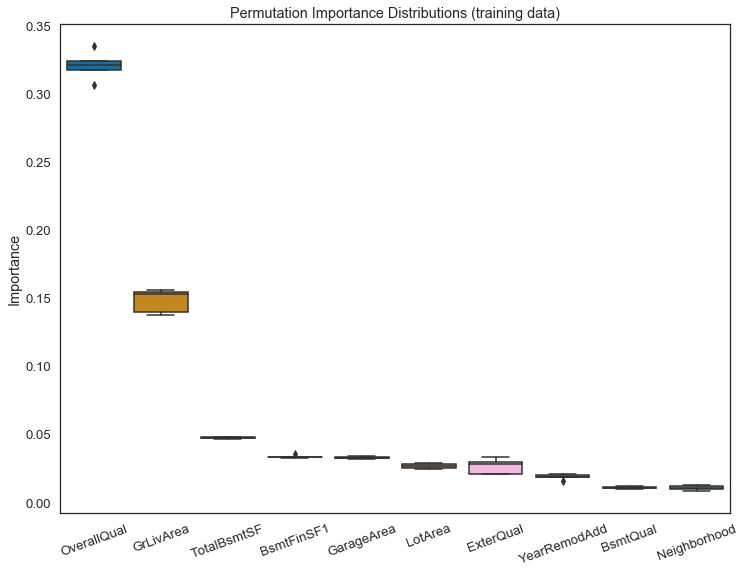

In [216]:
perm_train_feat_imp_df = pd.DataFrame(data=perm_train.results_, columns=features)

fig, ax = plt.subplots()
(sns.boxplot(ax=ax, data=perm_train_feat_imp_df[top]).set(title='Permutation Importance Distributions (training data)',
             ylabel='Importance'))
plt.xticks(rotation=20);

### Feature Contributions

In [217]:
train_expl_list = [eli5.explain_prediction_df(m, X_train.loc[i], feature_names=features) for i in X_train.index]

In [239]:
keys = [f'House #{i}' for i in X_train.index]
train_expl_df = pd.concat(train_expl_list, keys=keys, names=['Houses'])

train_expl_df.head(20)

target       feature         weight   value
Houses                                                    
House #781  0       y        <BIAS>  181186.254612     1.0
            1       y     ExterQual   15046.484771     3.0
            2       y     GrLivArea    8600.481899  1603.0
            3       y      FullBath    7513.053670     2.0
            4       y   OpenPorchSF    3273.481126   124.0
            5       y   GarageYrBlt    2714.869057  1992.0
            6       y  YearRemodAdd    1546.087856  1992.0
            7       y    GarageArea     414.909107   484.0
            8       y   LotFrontage     411.020168    65.0
            9       y  TotRmsAbvGrd     148.375328     7.0
            10      y    MasVnrArea      32.192853     0.0
            11      y      BsmtQual     -81.881745     3.0
            12      y      2ndFlrSF    -692.936478   793.0
            13      y    BsmtFinSF1    -846.219804   387.0
            14      y  Neighborhood   -1052.478217    21.0
            15      y       LotArea   -4619.653797  7153.0
            16      y   TotalBsmtSF  -10305.522110   761.0
            17      y   OverallQual  -24581.324620     6.0
House #1219 0       y        <BIAS>  181186.254612     1.0
            1       y  Neighborhood     572.618206     3.0

In [219]:
rf_pred = m.predict(X_train.loc[781].values.reshape(1, -1))
interp_pred = train_expl_df.loc['House #781'].weight.sum()

np.isclose(rf_pred, interp_pred)

array([ True])

In [220]:
valid_expl_list = [eli5.explain_prediction_df(m, X_valid.loc[i], feature_names=features) for i in X_valid.index]
keys = [f'House #{i}' for i in X_valid.index]
valid_expl_df = pd.concat(valid_expl_list, keys=keys, names=['Houses'])

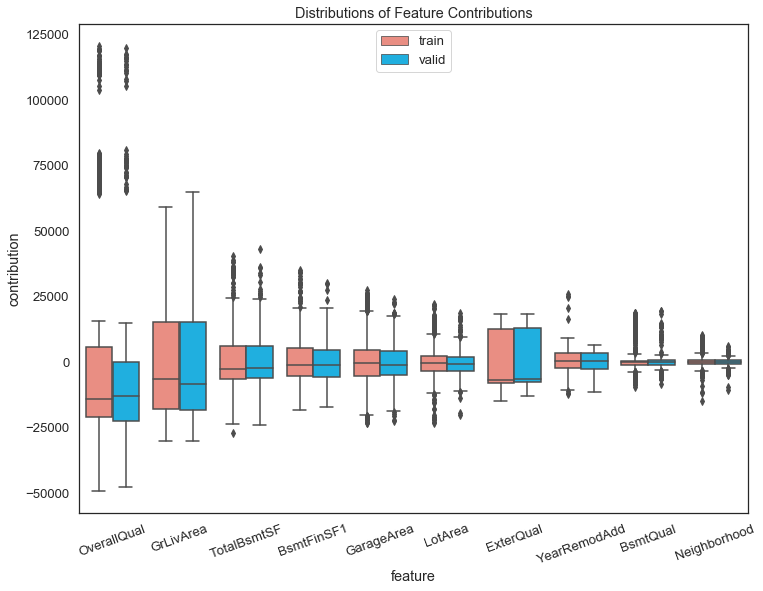

In [221]:
train_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)
valid_expl_df.rename(columns={'weight': 'contribution'}, inplace=True)

train_expl_df['data'] = 'train'
valid_expl_df['data'] = 'valid'

train_valid_expl_df = pd.concat([train_expl_df, valid_expl_df])

sns.boxplot(x='feature', y='contribution', hue='data', order=top,
            data=train_valid_expl_df.loc[train_valid_expl_df.feature.isin(top)],
            palette={'train': 'salmon', 
                     'valid':'deepskyblue'})
plt.legend(loc=9)
plt.title('Distributions of Feature Contributions')
plt.xticks(rotation=20);

In [222]:
train_scaled_feat_vals = (train_expl_df.groupby('feature')
                                       .value
                                       .transform(lambda x: x/x.max()))

train_expl_df['scaled_feat_vals'] = train_scaled_feat_vals

cmap = plt.get_cmap('viridis')
cbar_label = 'Feature Value %ile'

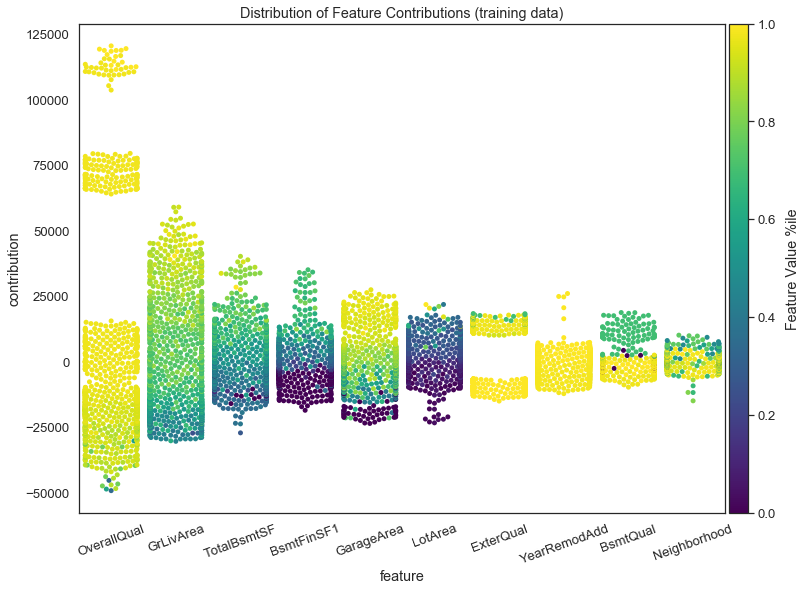

In [223]:
plt.title('Distribution of Feature Contributions (training data)')
plt.xticks(rotation=20)
fig = swarmplot_with_cbar(cmap, cbar_label,  x='feature', y='contribution',
                    hue='scaled_feat_vals', palette='viridis', order=top,
                    data=train_expl_df.loc[train_expl_df.feature.isin(top)]);

### Univariate and Partial Dependence

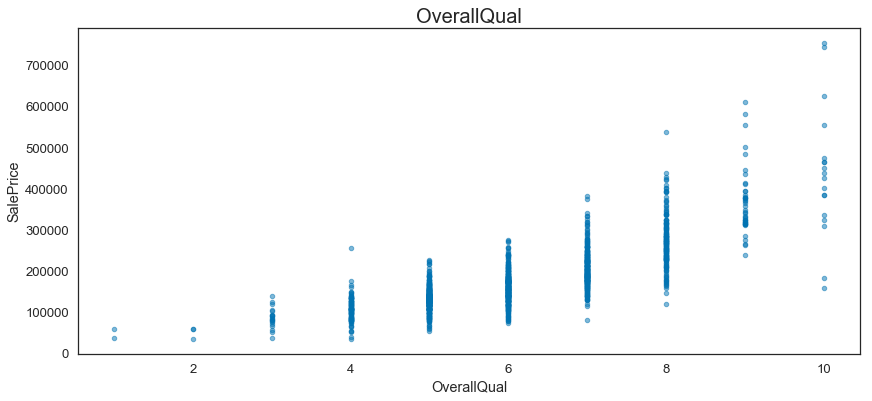

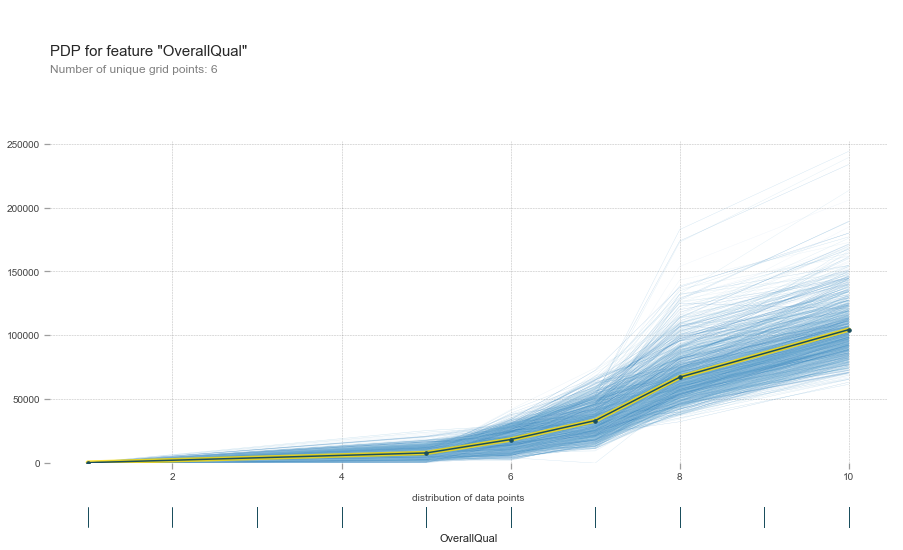

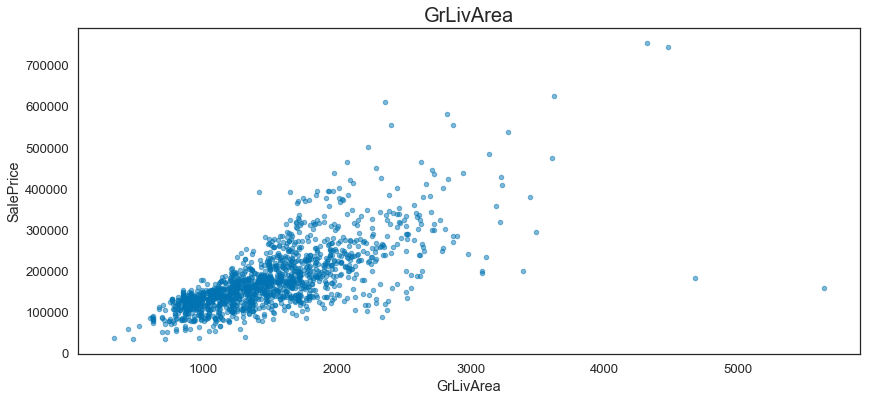

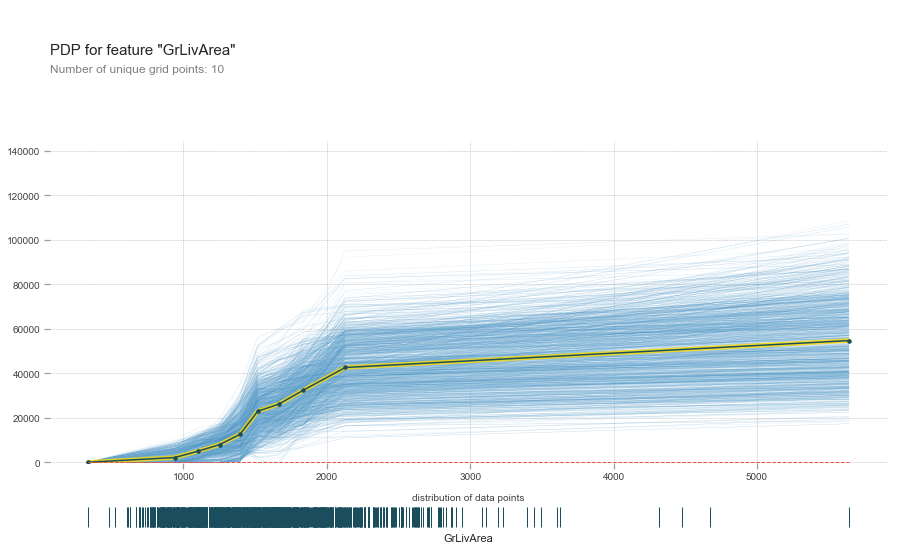

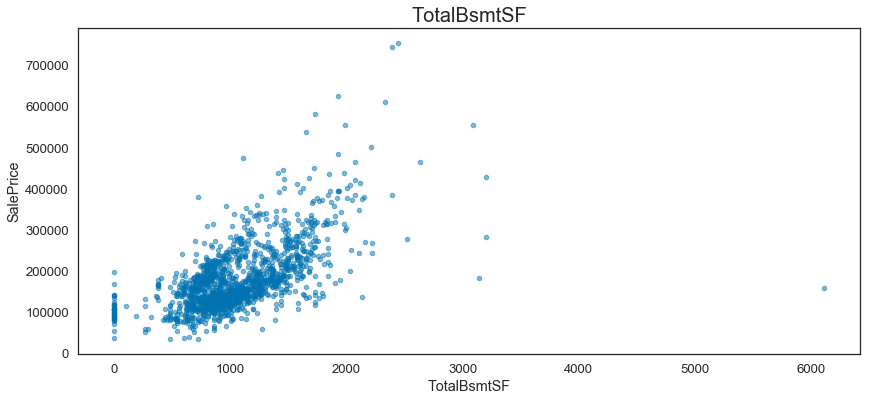

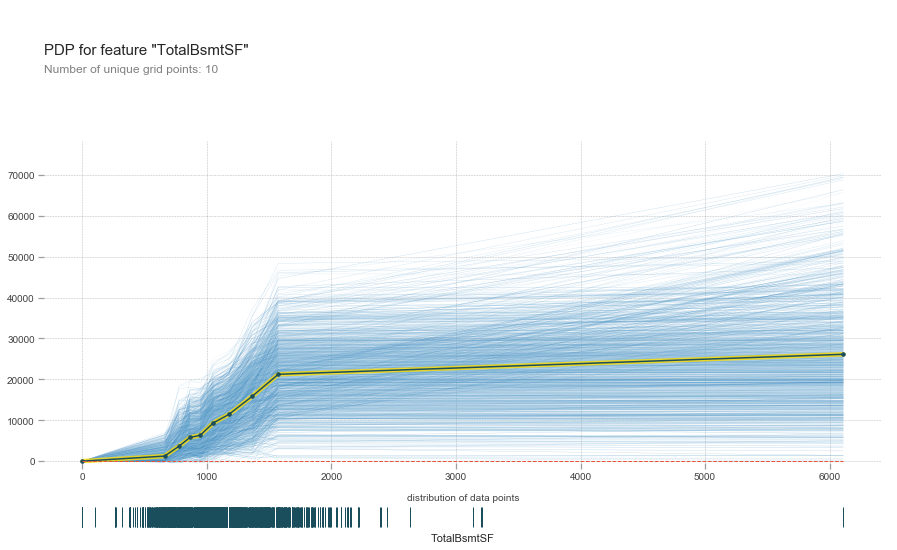

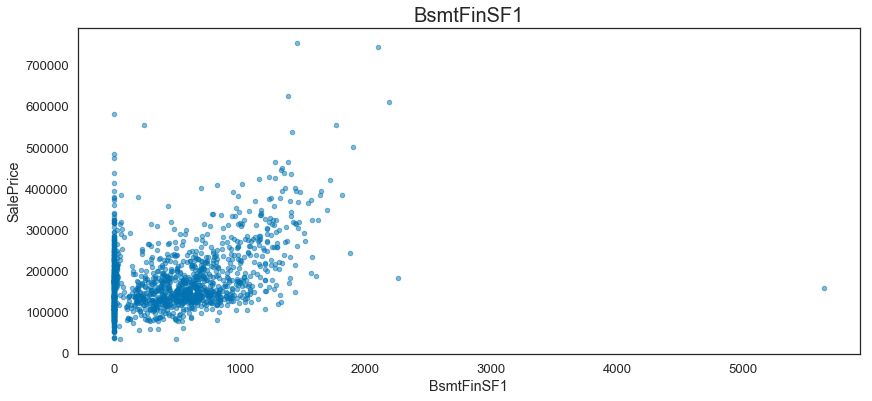

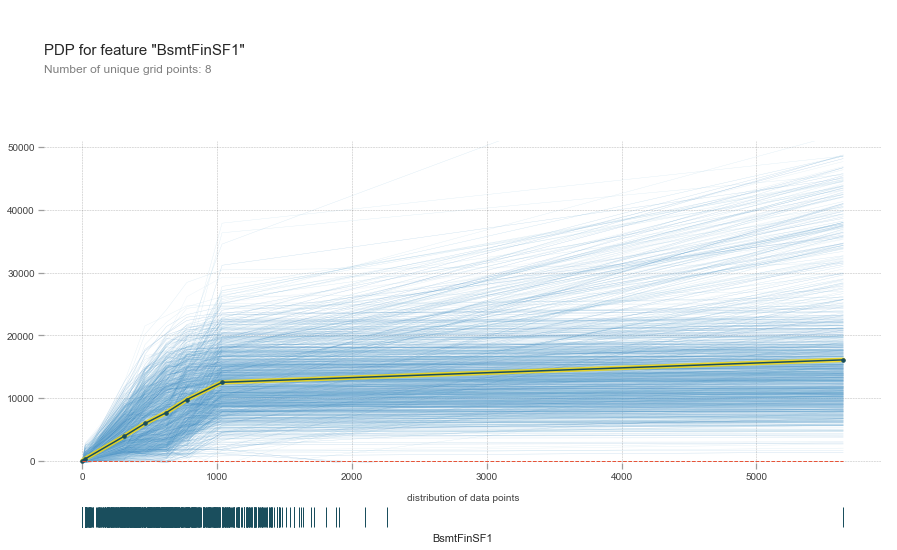

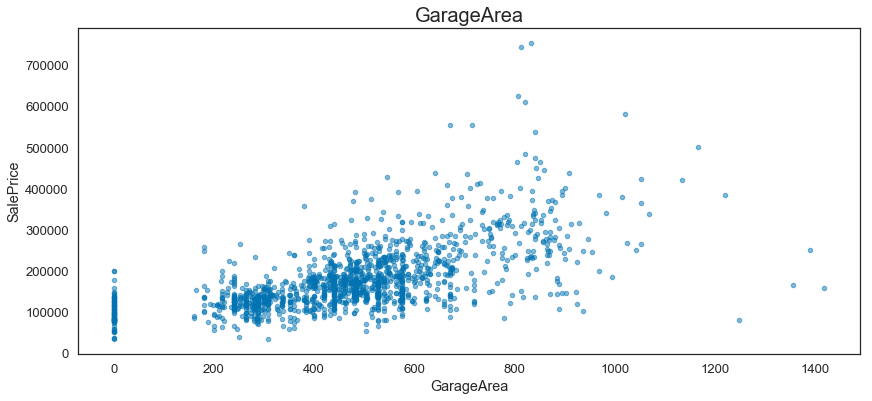

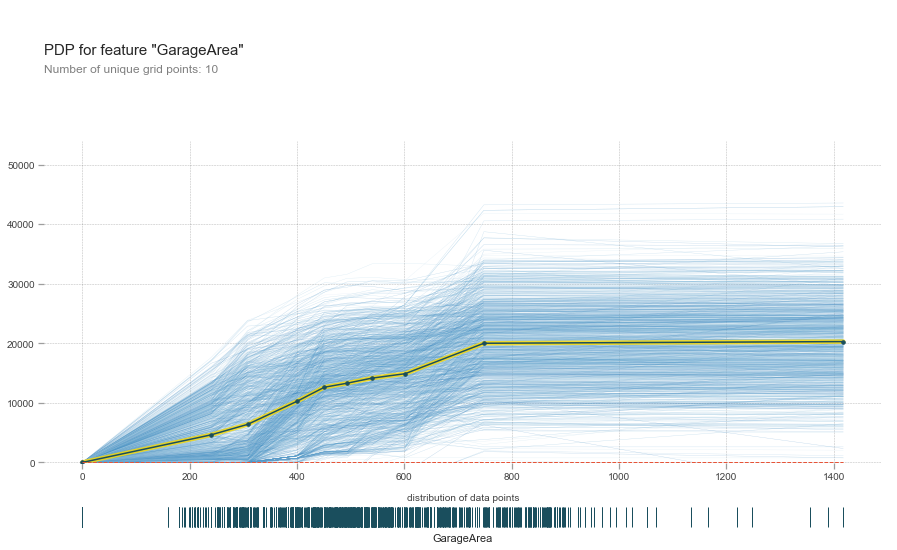

In [224]:
TARGET = 'SalePrice'

for feature in top[:5]:
    fig, ax = plt.subplots()
    data.plot(feature, TARGET, 'scatter', alpha=0.5, figsize=(14, 6), title=feature, ax=ax);
    ax.title.set_size(20)
    plot_pdp(m, X_train, features, feature);

### Feature Interactions

In [237]:
to_explore = [['OverallQual', 'GrLivArea'],
             ['GarageArea', 'LotArea'],
             ['TotalBsmtSF', 'BsmtFinSF1']]

C:\Users\Francesco\Anaconda3\envs\fraenv36\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'N'
  s)
C:\Users\Francesco\Anaconda3\envs\fraenv36\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'N'
  s)
C:\Users\Francesco\Anaconda3\envs\fraenv36\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'N'
  s)


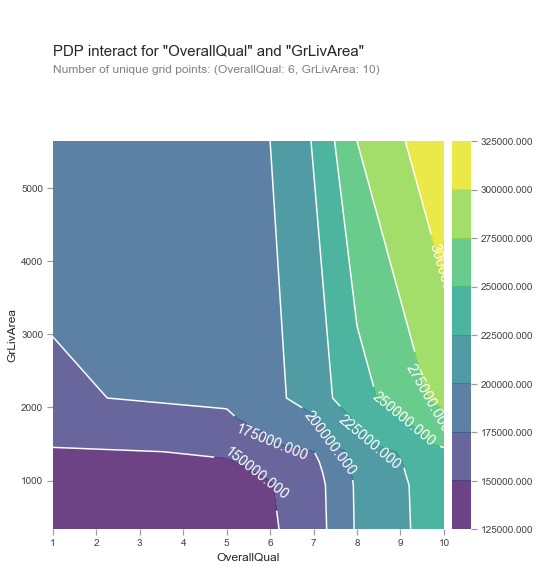

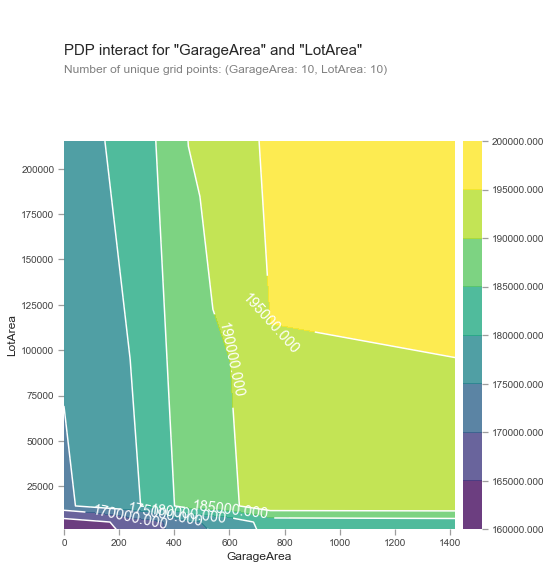

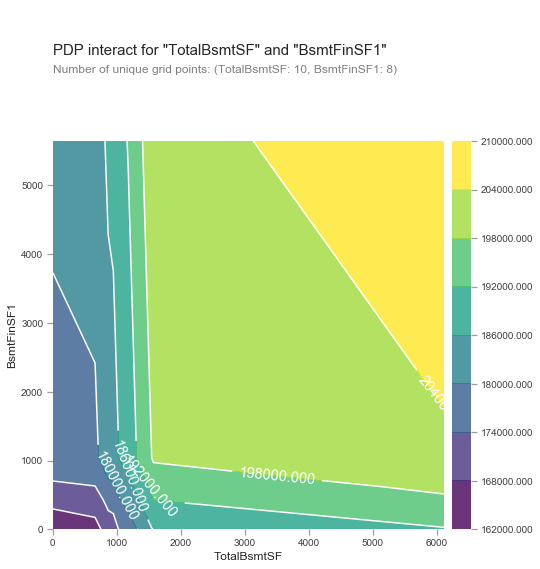

In [238]:
for i in range(len(to_explore)):
    feats = to_explore[i]
    p = pdp.pdp_interact(m, X_train, X_train.columns, feats)
    _ = pdp.pdp_interact_plot(p, feats)